### Introduction

In this assignment I investigate the thermal emission from an accretion disk by modeling its output as a multi colour blackbody. The goal is to compare the temperature profile obtained from a standard analytical formulation of a stationary thin disk with that computed numerically from the local viscous dissipation rate provided by disklab. By integrating the blackbody emission from each annulus of the disk we can obtain a spectral energy distribution or SED expressed in $ \nu L_\nu$, which shows the combined contribution of regions with varying temperatures.

We also perform parameter sweeps by varying the mass accretion rate, the inner disk radius, and the black hole mass. This is intended to reveal how these parameters influence the SED and to highlight potential degeneracies among them. For example, similar spectral shifts may arise from a higher accretion rate or a smaller inner radius. These concepts are showed in coursenotes 6, coursenotes 7 and coursenotes 9.

### Code Structure

Fn this project, we assume a disk around a 5 solar mass black hole with an inner radius of 0.1 AU and an outer radius of 1 AU. The mass accretion rate is set to 0.01 solar masses per year, and we adopt an alpha-viscosity parameter of 0.01. The disk is initialized using the DiskRadialModel from DISKLAB. The disk is then evolved over a series of timesteps during which the code updates the viscous evolution, recalculates the midplane properties, and computes the local viscous dissipation rate.

After the evolution phase, we compute two temperature profiles: an analytical profile derived from the standard thin disk formula and a numerical profile based on the viscous dissipation. These temperature profiles are then used to compute the local blackbody emission via the Planck function. The contributions from all annuli are integrated, taking into account the corresponding annular area, to produce the overall SED $\nu L_\nu$.

`compute_spectrum`,does the entire process, thereby making it easier to perform parameter sweeps over $\dot{M}$, $r_{\rm in}$, and $M_{\rm BH}$.

In [34]:
import disklab
from disklab import DiskRadialModel
import disklab.natconst 
from disklab.diskradial import *
from disklab.natconst import *
from snippets import *
import matplotlib.pyplot as plt
import numpy as np

# Define parameters for the disk model
MBH = 5 * MS  # Black hole mass
alpha = 1e-2  # Viscosity parameter
r_in = 0.1 * AU  # Inner disk radius in terms of r_g
r_out = 1*AU  # Outer disk radius in terms of r_g
Mdot = 0.01 * MS/year  # Mass accretion rate in terms of Eddington accretion rate


In [35]:
# Initialize the disk model with given parameters
d = DiskRadialModel(mstar=MBH, rin=r_in, rout=r_out, alpha=alpha)
d.make_disk_from_m_pl(mdisk=0.01 * MBH)

# Define the end time and number of time steps for the simulation
t_end = 1.5e100 * year                                              
ntime = 100
time = t_end ** (np.linspace(0, 1, ntime + 1))

# Set the mean opacity model and compute initial mean opacity
d.meanopacitymodel = ['es']
d.compute_mean_opacity()

# Evolve the disk model over the defined time steps
for t_step in range(1, ntime + 1):
    d.compute_nu()  # Compute the viscosity parameter
    # Update the surface density for the next time step
    d.sigma = d.get_viscous_evolution_next_timestep(time[t_step] - time[t_step - 1], sigma_innerbc=d.sigma[1] / 2, alphamodel=True, mdot_outerbc=Mdot)
    d.compute_disktmid(vischeat=True, simple=True)  # Compute the midplane temperature
    d.compute_cs_and_hp()  # Compute the sound speed and pressure scale height
    d.compute_rhomid_from_sigma()  # Compute the midplane density
    d.compute_mean_opacity()  # Recompute the mean opacity


### Disk Temperature Profiles

The simulation computes two distinct temperature profiles for the disk. First, I derive an analytical temperature profile using the well-known thin disk relation:

$$
\sigma_{\rm SB} T^4 = \frac{3GM\dot{M}}{8\pi R^3}\left[1-\sqrt{\frac{R_{\ast}}{R}}\right],
$$

which reflects the balance between viscous dissipation and radiative cooling in a stationary disk. Second, I calculate a temperature profile directly from the local viscous dissipation rate (represented by the variable d.qvisc) using the relation:

$$
T_{\rm visc} = \left(\frac{d.qvisc}{2\,\sigma_{\rm SB}}\right)^{1/4}.
$$

Comparing these two profiles verifies that the numerical evolution reproduces the expected theoretical behavior of a stationary thin disk (see coursenotes 6).

Peak Analytical Temperature: 1.10e+04 K
Peak Computed Temperature: 1.11e+04 K


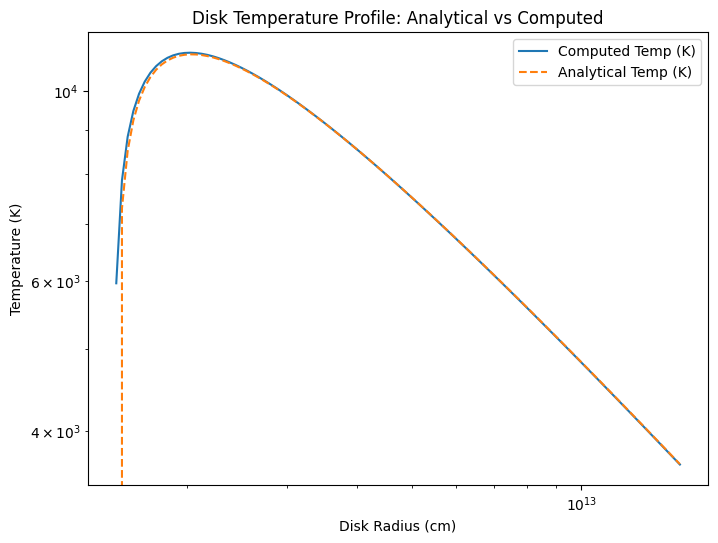

In [36]:
# Calculate the analytical temperature profile using the thin disk relation
T_analytical = ((3 * GG * MBH * Mdot * (1 - np.sqrt(r_in/d.r))) / (8 * ss * np.pi * d.r**3))**(1/4)

# Calculate the temperature profile from the local viscous dissipation rate
T_visc = (d.qvisc/(2*ss))**(1/4)

# Print the peak temperatures
print(f"Peak Analytical Temperature: {np.max(T_analytical):.2e} K")
print(f"Peak Computed Temperature: {np.max(T_visc):.2e} K")

# Plot the temperature profiles
plt.figure(figsize=(8,6), dpi=100)
plt.loglog(d.r, T_visc, label='Computed Temp (K)')
plt.loglog(d.r, T_analytical, label='Analytical Temp (K)', linestyle='--')
plt.xlabel('Disk Radius (cm)')
plt.ylabel('Temperature (K)')
plt.title("Disk Temperature Profile: Analytical vs Computed")
plt.legend()
plt.show()

### Spectral Energy Distribution Calculation

With the temperature profiles established, the next step is to compute the disk’s spectral energy distribution. To do this, I define a Planck function that calculates the local blackbody spectrum at a given frequency for each annulus in the disk. Each annulus’s contribution is weighted by its surface area, approximated as $2\pi R\,\Delta R$, and these contributions are summed over the entire disk to yield the overall SED, expressed as $\nu L_\nu$.

The resulting SED shows what is predicted in theory: a Rayleigh–Jeans tail at low frequencies, a broad peak corresponding to the range of temperatures in the disk, and an exponential cutoff at high frequencies. The SED of both the analytical temperature and the computed surface temperature are exactly the same.

Peak value (Computed Temp): 1.05e+37 erg/s at 5.94e+14 Hz
Peak value (Analytical Temp): 1.05e+37 erg/s at 5.94e+14 Hz


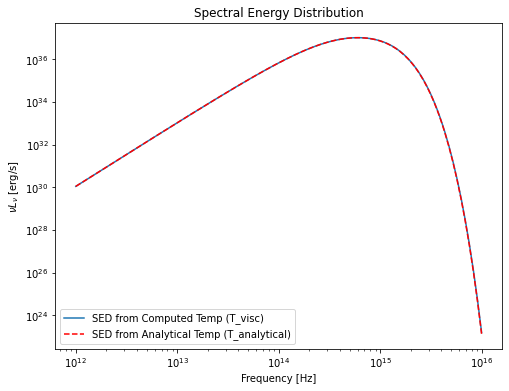

In [37]:
def planck(nu, T):
    with np.errstate(divide='ignore', invalid='ignore'):
        result = (2 * hh * nu**3 / cc**2) / (np.exp(hh * nu / (kk * T)) - 1)
        result[np.isnan(result)] = 0  # Replace NaNs with 0
        result[np.isinf(result)] = 0  # Replace infs with 0
    return result

nu = np.logspace(12, 16, 200)

# Compute SED using T_visc
spectrum_visc = np.zeros_like(nu)
dr = np.empty_like(d.r)
dr[0] = d.r[1] - d.r[0]
dr[1:-1] = 0.5 * (d.r[2:] - d.r[:-2])
dr[-1] = d.r[-1] - d.r[-2]
area = 2 * np.pi * d.r * dr  # area of each annulus

for i in range(len(d.r)):
    spectrum_visc += area[i] * planck(nu, T_visc[i])
nuLnu_visc = nu * spectrum_visc

# Compute SED using T_analytical
spectrum_analytical = np.zeros_like(nu)
for i in range(len(d.r)):
    spectrum_analytical += area[i] * planck(nu, T_analytical[i])
nuLnu_analytical = nu * spectrum_analytical

# Find the peak values and their corresponding frequencies
peak_value_visc = np.max(nuLnu_visc)
peak_freq_visc = nu[np.argmax(nuLnu_visc)]

peak_value_analytical = np.max(nuLnu_analytical)
peak_freq_analytical = nu[np.argmax(nuLnu_analytical)]

# Print the peak values and their corresponding frequencies
print(f"Peak value (Computed Temp): {peak_value_visc:.2e} erg/s at {peak_freq_visc:.2e} Hz")
print(f"Peak value (Analytical Temp): {peak_value_analytical:.2e} erg/s at {peak_freq_analytical:.2e} Hz")

# Plot both SEDs on the same figure
plt.figure(figsize=(8, 6))
plt.loglog(nu, nuLnu_visc, label="SED from Computed Temp (T_visc)")
plt.loglog(nu, nuLnu_analytical, 'r--', label="SED from Analytical Temp (T_analytical)")
plt.xlabel("Frequency [Hz]")
plt.ylabel(r"$\nu L_\nu$ [erg/s]")
plt.title("Spectral Energy Distribution")
plt.legend()
plt.show()

### Parameter Sweeps and Analysis

To more understand the sensitivity of the SED to various disk parameters, I conducted parameter sweeps in three areas. First, I varied the mass accretion rate $\dot{M}$ over a range of values. An increase in $\dot{M}$ generally results in a higher overall luminosity and shifts the disk temperature upward, leading to a spectrum that peaks at higher frequencies.

Next, I altered the inner disk radius $r_{\rm in}$. A smaller inner radius enables the hotter, inner regions of the disk to contribute more significantly to the emission, again shifting the SED towards higher frequencies. Conversely, a larger inner radius reduces the contribution from these regions, affecting the overall spectral shape.

Finally, I varied the black hole mass $M_{\rm BH}$. Changes in $M_{\rm BH}$ modify the gravitational potential and thus the temperature distribution across the disk. For a fixed $\dot{M}$, a higher mass generally leads to lower temperatures in the inner disk, which is reflected in the SED.

It is important to note that there are degeneracies between these parameters. For example, an increase in $\dot{M}$ might produce a similar spectral shift as a decrease in $r_{\rm in}$. The simulation here assumes a fixed face-on inclination, in practice the disk inclination can significantly alter the observed spectrum due to projection effects and Doppler boosting. (see coursenotes 6 and 7).

In [38]:
def compute_spectrum(MBH, rin, Mdot):
    # Create the disk model with given parameters
    d = DiskRadialModel(mstar=MBH, rin=rin, rout=r_out, alpha=alpha)
    d.make_disk_from_m_pl(mdisk=0.01 * MBH)
    
    # Define the end time and number of time steps
    t_end = 1.5e5 * year
    ntime = 100
    time_arr = t_end ** (np.linspace(0, 1, ntime + 1))
    
    # Set the mean opacity model and compute initial mean opacity
    d.meanopacitymodel = ['es']
    d.compute_mean_opacity()
    
    # Evolve the disk model over the defined time steps
    for t_step in range(1, ntime + 1):
        d.compute_nu()  # Compute the viscosity parameter
        d.sigma = d.get_viscous_evolution_next_timestep(
            time_arr[t_step] - time_arr[t_step - 1],
            sigma_innerbc=d.sigma[1] / 2,
            alphamodel=True,
            mdot_outerbc=Mdot,
        )
        d.compute_disktmid(vischeat=True, simple=True)  # Compute the midplane temperature
        d.compute_cs_and_hp()  # Compute the sound speed and pressure scale height
        d.compute_rhomid_from_sigma()  # Compute the midplane density
        d.compute_mean_opacity()  # Recompute the mean opacity

    # Calculate the temperature profile from the local viscous dissipation rate
    T_visc = (d.qvisc / (2 * ss)) ** (1 / 4)
    
    # Define frequency range
    nu = np.logspace(12, 16, 200)
    spectrum = np.zeros_like(nu)
    
    # Calculate the width of each annulus
    dr = np.empty_like(d.r)
    dr[0] = d.r[1] - d.r[0]
    dr[1:-1] = 0.5 * (d.r[2:] - d.r[:-2])
    dr[-1] = d.r[-1] - d.r[-2]
    
    # Calculate the area of each annulus
    area = 2 * np.pi * d.r * dr
    
    # Sum the contribution of each annulus to the spectrum
    for i in range(len(d.r)):
        spectrum += area[i] * planck(nu, T_visc[i])
    
    # Calculate the spectral energy distribution
    nuLnu = nu * spectrum
    
    return nu, nuLnu

Peak value (Mdot = 0.01 * MS/year): 1.05e+37 erg/s at 5.94e+14 Hz
Peak value (Mdot = 0.03 * MS/year): 3.16e+37 erg/s at 7.84e+14 Hz
Peak value (Mdot = 0.05 * MS/year): 5.27e+37 erg/s at 9.01e+14 Hz
Peak value (Mdot = 0.07 * MS/year): 7.38e+37 erg/s at 9.88e+14 Hz
Peak value (Mdot = 0.10 * MS/year): 1.05e+38 erg/s at 1.08e+15 Hz


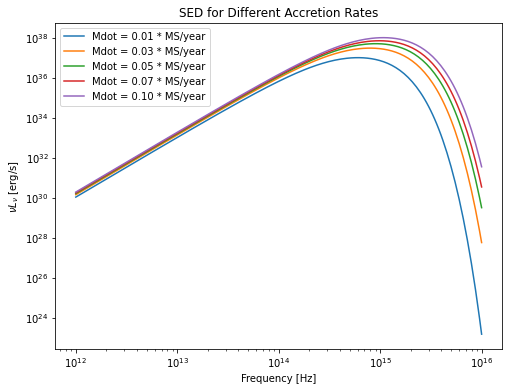

In [39]:
# Sweep over different mass accretion rates (Mdot)
mdot_list = [0.01, 0.03, 0.05, 0.07, 0.1]  # List of mass accretion rates to test
plt.figure(figsize=(8, 6))  # Create a new figure for plotting

# Loop over each mass accretion rate
for fac in mdot_list:
    current_mdot = fac * MS/year  # Convert mass accretion rate to cgs units
    nu, nuLnu = compute_spectrum(MBH, r_in, current_mdot)  # Compute the spectrum for the current parameters
    print(f"Peak value (Mdot = {fac:.2f} * MS/year): {np.max(nuLnu):.2e} erg/s at {nu[np.argmax(nuLnu)]:.2e} Hz")
    plt.loglog(nu, nuLnu, label=f"Mdot = {fac:.2f} * MS/year")  # Plot the spectrum with a label

# Add labels and title to the plot
plt.xlabel("Frequency [Hz]")
plt.ylabel(r"$\nu L_\nu$ [erg/s]")
plt.title("SED for Different Accretion Rates")
plt.legend()  # Add a legend to the plot
plt.show()  # Display the plot

Peak value (r_in = 0.05 * AU): 2.16e+37 erg/s at 9.44e+14 Hz
Peak value (r_in = 0.06 * AU): 1.80e+37 erg/s at 8.60e+14 Hz
Peak value (r_in = 0.07 * AU): 1.53e+37 erg/s at 7.49e+14 Hz
Peak value (r_in = 0.08 * AU): 1.34e+37 erg/s at 6.83e+14 Hz
Peak value (r_in = 0.1 * AU): 1.05e+37 erg/s at 5.94e+14 Hz


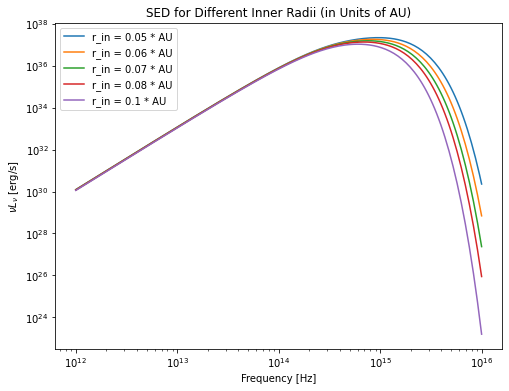

In [40]:
# Sweep over different inner radii defined as multiples of AU
factor_list = [0.05, 0.06, 0.07, 0.08, 0.1]  # List of factors to multiply with AU
plt.figure(figsize=(8, 6))  # Create a new figure for plotting

# Loop over each factor
for factor in factor_list:
    current_rin = factor * AU  # Calculate the current inner radius
    nu, nuLnu = compute_spectrum(MBH, current_rin, Mdot)  # Compute the spectrum for the current parameters
    print(f"Peak value (r_in = {factor} * AU): {np.max(nuLnu):.2e} erg/s at {nu[np.argmax(nuLnu)]:.2e} Hz")
    plt.loglog(nu, nuLnu, label=f"r_in = {factor} * AU")  # Plot the spectrum with a label

# Add labels and title to the plot
plt.xlabel("Frequency [Hz]")
plt.ylabel(r"$\nu L_\nu$ [erg/s]")
plt.title("SED for Different Inner Radii (in Units of AU)")
plt.legend()  # Add a legend to the plot
plt.show()  # Display the plot

Peak value (MBH = 5 * MS): 1.05e+37 erg/s at 5.94e+14 Hz
Peak value (MBH = 10 * MS): 2.11e+37 erg/s at 7.15e+14 Hz
Peak value (MBH = 15 * MS): 3.16e+37 erg/s at 7.84e+14 Hz
Peak value (MBH = 20 * MS): 4.22e+37 erg/s at 8.60e+14 Hz
Peak value (MBH = 25 * MS): 5.27e+37 erg/s at 9.01e+14 Hz


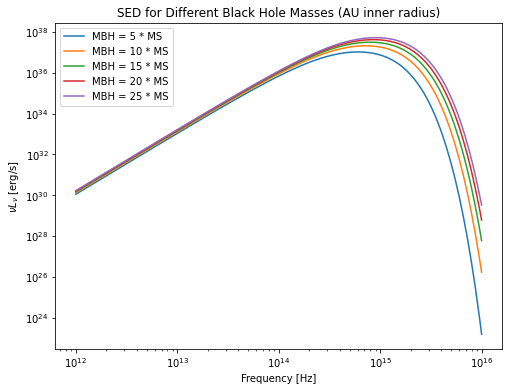

In [41]:
# Sweep over different black hole masses
BH_mass_list = [5, 10, 15, 20, 25]  # multiples of MS
plt.figure(figsize=(8, 6))  # Create a new figure for plotting

# Loop over each black hole mass
for mass_fac in BH_mass_list:
    current_MBH = mass_fac * MS  # Calculate the current black hole mass
    current_rin = 0.1*AU  # Set the inner radius to 6*r_g
    nu, nuLnu = compute_spectrum(current_MBH, current_rin, Mdot)  # Compute the spectrum for the current parameters
    print(f"Peak value (MBH = {mass_fac} * MS): {np.max(nuLnu):.2e} erg/s at {nu[np.argmax(nuLnu)]:.2e} Hz")
    plt.loglog(nu, nuLnu, label=f"MBH = {mass_fac} * MS")  # Plot the spectrum with a label

# Add labels and title to the plot
plt.xlabel("Frequency [Hz]")
plt.ylabel(r"$\nu L_\nu$ [erg/s]")
plt.title("SED for Different Black Hole Masses (AU inner radius)")
plt.legend()  # Add a legend to the plot
plt.show()  # Display the plot

### Discussion and Conclusions

In conclusion, the simulation successfully models the thermal emission from an accretion disk as a multi-color blackbody. The close agreement between the analytical temperature profile and the one derived from the local viscous dissipation rate confirms that the numerical evolution is consistent with the standard thin disk theory (see coursenotes 6).

The resulting spectral energy distribution exhibits all the expected features: a low-frequency Rayleigh–Jeans tail, a broad peak representing the superposition of emissions from a range of disk temperatures, and an exponential cutoff at high frequencies. The parameter sweeps illustrate that variations in the mass accretion rate, inner disk radius, and black hole mass can produce similar shifts in the spectrum, revealing underlying degeneracies. 

Overall, this study demonstrates how variations in some parameters can be used to interpret the spectral signatures of accretion disks. These insights provide a start to explore more complex, time-dependent disk phenomena and for maybe incorporating additional physics such as advective processes or magnetohydrodynamic effects (see coursenotes 9 and 10).

All quantities are computed in cgs units, and the choices made for timesteps and boundary conditions ensure that the simulation remains stable and converges appropriately, in full accordance with the guidelines provided in the course notes and in talks with the TAs. 